In [1]:
from PIL import Image
import math
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
# XYZ Reference values from easyRGB.com
# Illuminant = D65 and Observer = 2 for sRGB
referenceX = 95.047
referenceY = 100.000
referenceZ = 108.883

In [3]:
# General functions

# Opens image as numpy array
def openImg(filename):
    im = Image.open(filename)
    mode = im.mode
    im = np.array(im, dtype=np.uint8)
    if (mode == "RGBA"):
        im = im[:, :, :3]
    return im

# Adapted from easyRGB.com
# Takes RGB values -> XYZ -> Lab
def rgb2lab(rgb):
    # sRGB to XYZ
    R = rgb[0] / 255
    G = rgb[1] / 255
    B = rgb[2] / 255
    
    if R > 0.04045:
        R = math.pow(((R + 0.055) / 1.055), 2.4)
    else:
        R /= 12.92
    if G > 0.04045:
        G = math.pow(((G + 0.055) / 1.055), 2.4)
    else:
        G /= 12.92
    if B > 0.04045:
        B = math.pow(((B + 0.055) / 1.055), 2.4)
    else:
        B /= 12.92
        
    R *= 100
    G *= 100
    B *= 100
    
    X = (R * 0.4124) + (G * 0.3576) + (B * 0.1805)
    Y = (R * 0.2126) + (G * 0.7152) + (B * 0.0722)
    Z = (R * 0.0193) + (G * 0.1192) + (B * 0.9505)
    
    # XYZ to Lab
    X /= referenceX
    Y /= referenceY
    Z /= referenceZ
    
    if X > 0.008856:
        X = math.pow(X, 1/3)
    else:
        X = (7.787 * X) + (16 / 116)
    if Y > 0.008856:
        Y = math.pow(Y, 1/3)
    else:
        Y = (7.787 * Y) + (16 / 116)
    if Z > 0.008856:
        Z = math.pow(Z, 1/3)
    else:
        Z = (7.787 * Z) + (16 / 116)
        
    L = (116 * Y) - 16
    a = 500 * (X - Y)
    b = 200 * (Y - Z)
    
    return [L, a, b]

# Adapted from easyRGB.com
# Takes Lab values -> XYZ -> RGB
def lab2rgb(Lab):
    # Lab to XYZ
    Y = (Lab[0] + 16) / 116
    X = Lab[1] / 500 + Y
    Z = Y - Lab[2] / 200
    
    if math.pow(Y, 3) > 0.008856:
        Y = math.pow(Y, 3)
    else:
        Y = (Y - 16 / 116) / 7.787
    if math.pow(X, 3) > 0.008856:
        X = math.pow(X, 3)
    else:
        X = (X - 16 / 116) / 7.787
    if math.pow(Z, 3) > 0.008856:
        Z = math.pow(Z, 3)
    else:
        Z = (Z - 16 / 116) / 7.787
        
    X *= referenceX
    Y *= referenceY
    Z *= referenceZ
    
    # XYZ to sRGB
    X /= 100
    Y /= 100
    Z /= 100
    
    R = X *  3.2406 + Y * -1.5372 + Z * -0.4986
    G = X * -0.9689 + Y *  1.8758 + Z *  0.0415
    B = X *  0.0557 + Y * -0.2040 + Z *  1.0570
    
    if R > 0.0031308:
        R = 1.055 * math.pow(R, 1/2.4) - 0.055
    else:
        R *= 12.92
    if G > 0.0031308:
        G = 1.055 * math.pow(G, 1/2.4) - 0.055
    else:
        G *= 12.92
    if B > 0.0031308:
        B = 1.055 * math.pow(B, 1/2.4) - 0.055
    else:
        B *= 12.92
        
    R *= 255
    G *= 255
    B *= 255
    
    R = round(min(max(R, 0), 255))
    G = round(min(max(G, 0), 255))
    B = round(min(max(B, 0), 255))
    
    return [R, G, B]

# Calculate the distance between two colors in Lab space
# Inputs:
#     L1, a1, b1: Lab value of first color
#     L2, a2, b2: Lab value of second color  
def getLabDistance(L1, a1, b1, L2, a2, b2):
    L = L1-L2
    a = a1-a2
    b = b1-b2
    return math.sqrt((L*L)+(a*a)+(b*b))

In [4]:
# Color Palette Selection
def binRGB(image):
    bins = np.zeros((16*16*16,4), dtype=int)
    for c in range(len(image)):
        for r in range(len(image[0])):
            rgb = image[c][r]
            rgb = np.array([rgb[0], rgb[1], rgb[2], 1], dtype=int)
            binR = rgb[0]//16
            binG = rgb[1]//16
            binB = rgb[2]//16
            bindex = binR + binG * 16 + binB * 16 * 16
            bins[bindex] += [rgb[0], rgb[1], rgb[2], 1]
    for i in range(len(bins)):
        if bins[i][3] != 0:
            rgb = bins[i][:3]/bins[i][3]
            rgb = [round(rgb[0]), round(rgb[1]), round(rgb[2]), bins[i][3]]
            bins[i] = rgb
    bins = bins[np.all(bins != 0, axis=1)]
    return bins
    
def kmeans(k, bins):
    palette = np.zeros((k+1,3), dtype=int)
    for p in range(k):
        maxCount = 0
        for bindex in range(len(bins)):
            if bins[bindex][3] > bins[maxCount][3]:
                maxCount = bindex
        palette[p] = bins[maxCount][:3]
        
        p_lab = rgb2lab(palette[p])
        for bindex in range(len(bins)):
            c_lab = rgb2lab(bins[bindex][:3])
            lab_dist = getLabDistance(p_lab[0],p_lab[1],p_lab[2],c_lab[0],c_lab[1],c_lab[2])
            sigma = 80
            bins[bindex][3] *= (1 - math.exp(-math.pow(lab_dist,2)/math.pow(sigma,2)))
    return palette

[[ 86  84  89]
 [ 88 116 156]
 [ 56  54  25]
 [250 214 168]
 [ 28  39  57]
 [  0   0   0]]


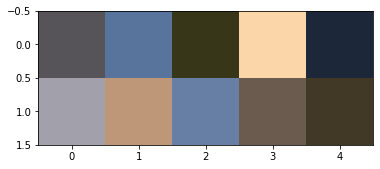

In [5]:
im = openImg('sample.png')
bins = binRGB(im)
palette = kmeans(5, bins)
print(palette)
canvas = np.zeros((2,5,3), dtype=np.uint8)
for i in range(5):
    canvas[0][i] = palette[i]
canvas[1][0] = [162, 160, 170]
canvas[1][1] = [190, 151, 120]
canvas[1][2] = [104, 127, 165]
canvas[1][3] = [107, 91, 79]
canvas[1][4] = [65, 57, 38]
plt.imshow(canvas)

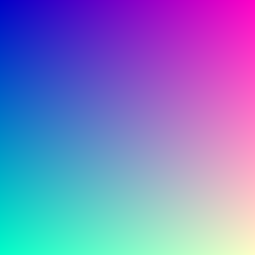

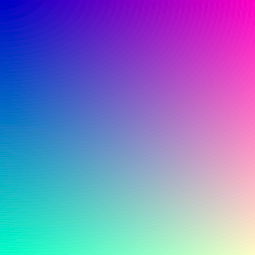

In [6]:
def testColorConversion1():
    im = np.zeros(shape = (255, 255, 3), dtype=np.uint8)
    for y in range(len(im)):
        for x in range(len(im[0])):
            im[y][x] = [x, y, 200]

    im_lab = np.zeros(shape = (255, 255, 3), dtype=int)
    for c in range(len(im_lab)):
        for r in range(len(im_lab[0])):
            im_lab[c][r] = rgb2lab(im[c][r])

    im_rgb = np.zeros(shape = (255, 255, 3), dtype=np.uint8)
    for c in range(len(im_rgb)):
        for r in range(len(im_rgb[0])):
            im_rgb[c][r] = lab2rgb(im_lab[c][r])

    imPIL = Image.fromarray(im.astype('uint8'), 'RGB')
    im_rgbPIL = Image.fromarray(im_rgb.astype('uint8'), 'RGB')
    display(imPIL, im_rgbPIL)
    
testColorConversion1()

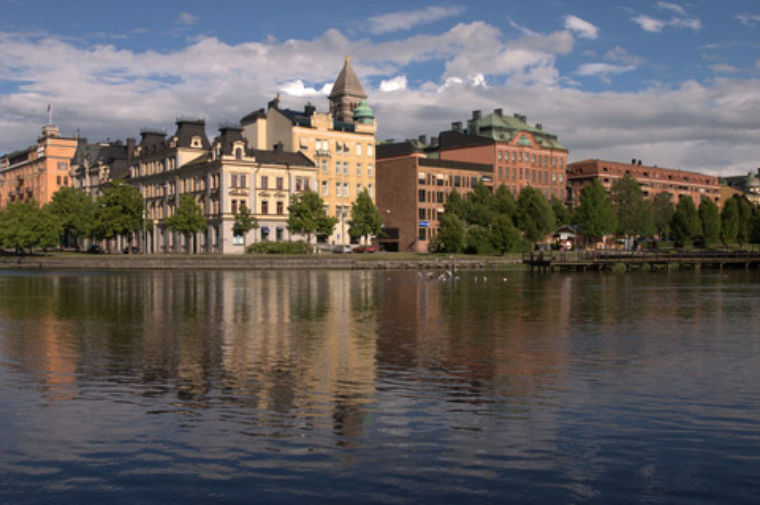

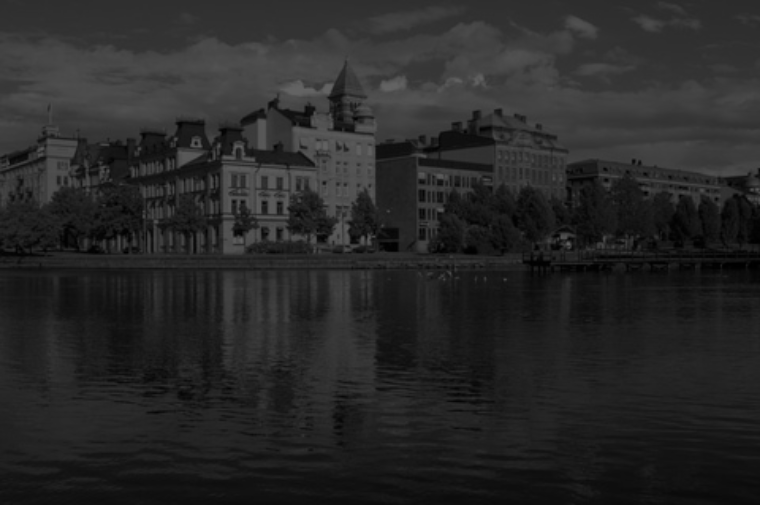

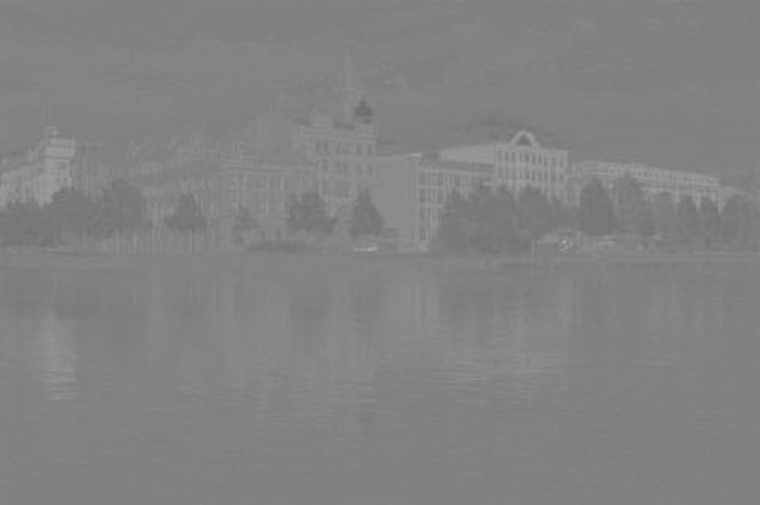

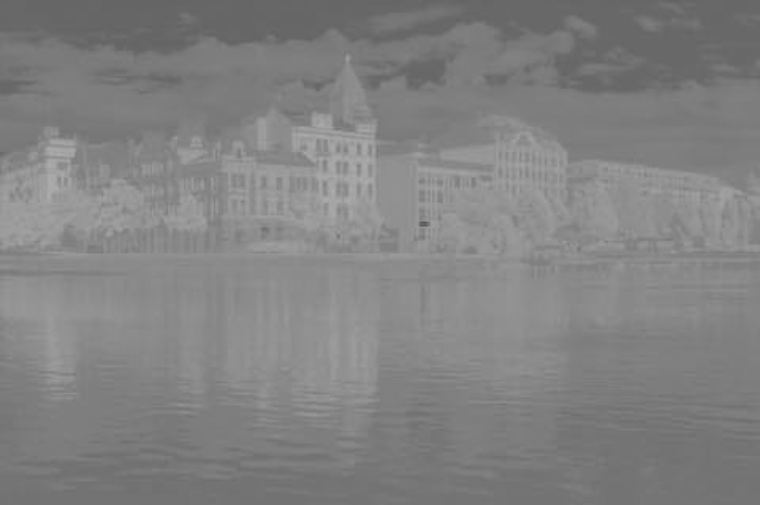

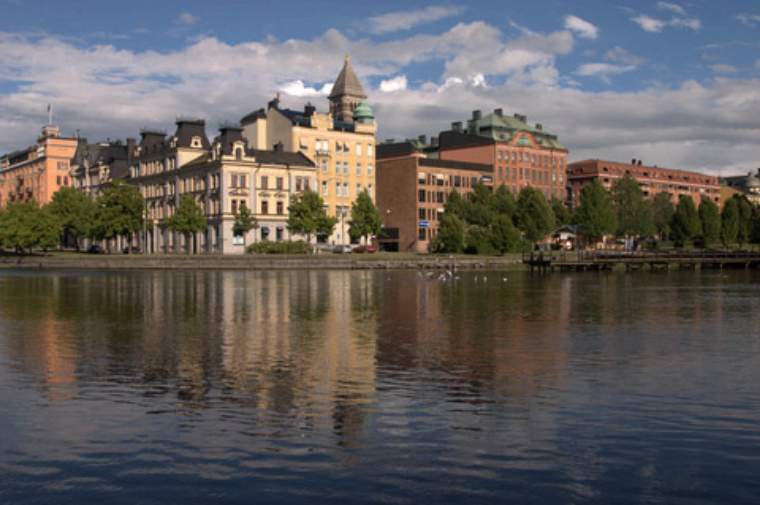

In [7]:
def testColorConversion2():
    im = openImg('sample.png')
    im_lab = np.zeros(im.shape, dtype=int)
    for c in range(len(im_lab)):
        for r in range(len(im_lab[0])):
            im_lab[c][r] = rgb2lab(im[c][r])

    im_rgb = np.zeros(im.shape, dtype=np.uint8)
    for c in range(len(im_rgb)):
        for r in range(len(im_rgb[0])):
            im_rgb[c][r] = lab2rgb(im_lab[c][r])

    imPIL = Image.fromarray(im.astype('uint8'), 'RGB')
    im_labPIL = Image.fromarray(im_lab.astype('uint8'), 'LAB')
    im_rgbPIL = Image.fromarray(im_rgb.astype('uint8'), 'RGB')
    L,a,b = im_labPIL.split()
    display(imPIL, L, a, b, im_rgbPIL)

testColorConversion2()